# Spatial biases

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import math
import os
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.utils import short_iid
from tools import (
    check_equal_period,
    create_cordex_grid,
    fix_360_longitudes,
    load_obs,
    mask_invalid,
    open_datasets,
    regrid_dsets,
    seasonal_mean,
    standardize_unit,
    var_dic,
    e_obs_dic,
    variable_mapping,
    height_temperature_correction,
)

dask.config.set(scheduler="single-threaded")

In [45]:
client = Client(dashboard_address="localhost:8787", threads_per_worker=1)
client

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33581 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:43597' processes=16 threads=16, memory=125.79 GiB>

In [222]:
variable = "tas"
frequency = "mon"
domain = "EUR-11"
regridding = "bilinear"
period_star = "1989"
period_stop = "2008"   
period_star = "1991"
period_stop = "2020" 
parent = False

In [223]:
period = slice(period_star, period_stop)

In [224]:
save_results_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "intermediate-results")
)
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

In [225]:
rotated_grid = create_cordex_grid("EUR-11")  # No matter CMIP5 or CMIP6

## E-OBS is used as the reference dataset for all the analysis
It is used to calculate bias not only respect to CORDEX, but also in comparison wit other reanalyses and observational dataset, to assess the uncertaintly of the observational dataset

In [226]:
# load, regrid and calculate seasonal means
eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
eobs = obs.eobs(variables=eobs_var, add_mask=False).sel(time=period)
eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)
eobs = standardize_unit(eobs, variable)
# eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method=regridding, unmapped_to_nan=True)
ref_on_rotated = regridder(eobs)
if not check_equal_period(ref_on_rotated, period):
    print(f"Temporal coverage of dataset does not match with {period}")
ref_seasmean = seasonal_mean(ref_on_rotated[eobs_var].sel(time=period)).compute()

Convert celsius to kelvin


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.90 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## CERRA and ERA5

In [227]:
dsets = {}
for dset in var_dic[variable]["datasets"]:
    ds = load_obs(variable, dset, add_fx=True, mask=True)
    ds = ds.sel(time=period).compute()
    ds = fix_360_longitudes(ds, lonname="longitude")
    if not variable_mapping[dset][variable] == variable:
        ds = ds.rename_vars({variable_mapping[dset][variable]: variable})
    ds = standardize_unit(ds, variable)
    dsets[dset] = ds

merging era5 with orog
merging era5 with sftlf


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


merging cerra with orog
merging cerra with sftlf


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 18.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [228]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coveÇrage of {dset} does not match with {period}")

In [229]:
for dset, ds in dsets.items():
    regridder = xe.Regridder(ds, rotated_grid, method=regridding, unmapped_to_nan=True)
    dsets[dset] = regridder(ds)
    #mask with sftf and correct heigh with elevation

In [230]:
if variable == 'tas':
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]['tas'] = dsets[dset].tas - h_c.fillna(0)

In [231]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
obs_seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: x, diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

# CMIP6

In [232]:
mip_era = "CMIP6"
driving_source_id = "ERA5"

In [233]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Found: ['ALARO1-SFX', 'CCLM6-0-1-URB', 'CCLM6-0-1-URB-ESG', 'CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020-2-2', 'REMO2020-2-2-MR2', 'REMO2020-2-2-iMOVE', 'REMO2020-2-2-iMOVE-LUC', 'RegCM5-0'] for variables: ['tas']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.mon.v20250515
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.mon.v20250515: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.fx.v20241120
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.fx.v20241120: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.fx.v20241120: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.CNRM-ESM2-1.ssp370.r1i1p1f2.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(


Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328 will be ignored...


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
  warnings.warn(message)


Fix failed for CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
Dataset CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415 will be ignored...
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: "Receive multiple variables for key 'grid_mapping': ['rotated_pole', 'crs']. Expected only one. Please pass a list ['grid_mapping'] instead to get all variables matching 'grid_mapping'."
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: Found multiple grid mapping variables ['rotated_pole', 'crs']
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: Using crs as the grid mapping variable name. Please check the 

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
  warnings.warn(message)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(


Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328 will be ignored...
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.mon.v20250515 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.fx.v20250515
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v20241120 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.fx.v20241120
merging CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 with CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.fx.v20241009
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p

In [234]:
for dset in dsets.keys():
    dsets[dset] = dsets[dset].sel(time=period)

In [235]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

Temporal coverage of CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 does not match with slice('1991', '2020', None)


In [236]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

In [237]:
rotated_grid = create_cordex_grid(domain)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_483x483_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (483, 483) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250505 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       b

In [238]:
if variable == 'tas':
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]['tas'] = dsets[dset].tas - h_c.fillna(0)

In [239]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["source_id"], delimiter="-"),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.56 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-pa

In [240]:
seasonal_bias.to_netcdf(f"{save_results_path}/{variable}_{mip_era}_{period.start}-{period.stop}_spatial_bias.nc")

# CMIP5

In [241]:
mip_era = "CMIP5"
driving_source_id = "ERAINT"

In [242]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Found: ['ALADIN53', 'ALADIN63', 'ALARO-0', 'CCLM4-8-17', 'COSMO-crCLIM-v1-1', 'HadREM3-GA7-05', 'RACMO22E', 'RCA4', 'REMO2009', 'REMO2015', 'RegCM4-2'] for variables: ['tas']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.fx.v20200706
Warning for CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.fx.v20200706: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.fx.v20200706: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 22 datasets
decoding dataset CORDEX.EUR-11.KNMI.ERAINT.evaluation.r1i1p1.RACMO22E.v1.fx.v20140218
Found 22 datasets
decoding dataset CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r1i1p1.CCLM4-8-17.v1.mon.v20140515
Found 22 datasets
decoding dataset CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r1i1p1.REMO2009.v1.mon.v20160525
Found 22 datasets
decoding dataset CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.mon.v20200330
Found 22 datasets
decoding dataset CORDEX.EUR-11.CLMcom-ETH.ERAINT.evaluation.r0i0p0.COSMO-crCLIM-v1-1.v1.fx.v20191210
Found 22 datasets
decoding dataset CO

In [243]:
for dset in dsets.keys():
    dsets[dset] = dsets[dset].sel(time=period)

In [244]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

Temporal coverage of CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r1i1p1.CCLM4-8-17.v1.mon.v20140515 does not match with slice('1991', '2020', None)
Temporal coverage of CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r1i1p1.REMO2009.v1.mon.v20160525 does not match with slice('1991', '2020', None)
Temporal coverage of CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.mon.v20200330 does not match with slice('1991', '2020', None)
Temporal coverage of CORDEX.EUR-11.KNMI.ERAINT.evaluation.r1i1p1.RACMO22E.v1.mon.v20140319 does not match with slice('1991', '2020', None)
Temporal coverage of CORDEX.EUR-11.CLMcom-ETH.ERAINT.evaluation.r1i1p1.COSMO-crCLIM-v1-1.v1.mon.v20191210 does not match with slice('1991', '2020', None)
Temporal coverage of CORDEX.EUR-11.RMIB-UGent.ERAINT.evaluation.r1i1p1.ALARO-0.v1.mon.v20170207 does not match with slice('1991', '2020', None)
Temporal coverage of CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127 does not match with slice('1991', '2020', 

In [245]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

Convert celsius to kelvin


In [246]:
rotated_grid = create_cordex_grid(domain)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX.EUR-11.RMIB-UGent.ERAINT.evaluation.r1i1p1.ALARO-0.v1.mon.v20170207 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_485x485_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (485, 485) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.mon.v20191118 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_4

In [247]:
if variable == 'tas':
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]['tas'] = dsets[dset].tas - h_c.fillna(0)

In [248]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["source_id"], delimiter="-"),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

In [249]:
seasonal_bias.to_netcdf(f"{save_results_path}/{variable}_{mip_era}_{period.start}-{period.stop}_spatial_bias.nc")

# Plot

In [250]:
CMIP6_seasonal_bias = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP6_{period.start}-{period.stop}_spatial_bias.nc"
)
CMIP5_seasonal_bias = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP5_{period.start}-{period.stop}_spatial_bias.nc"
)

In [251]:
eur_colors = pd.read_csv("eurocordex_models.csv")

In [252]:
projects = ["CMIP5", "CMIP6"]
models_cmip6 = eur_colors[eur_colors["mip_era"] == "CMIP6"]["model"].values
parents_cmip6 = eur_colors[eur_colors["mip_era"] == "CMIP6"]["parent"].values
parents_cmip6[
    eur_colors[eur_colors["mip_era"] == "CMIP6"]["parent_mip_era"] == "CMIP6"
] = np.nan

In [253]:
if parent == True:

    parent_str = 'parent'
    models = []
    for m5, m6 in zip(parents_cmip6, models_cmip6):
        models.append(f"cmip5_{m5}")
        models.append(f"cmip6_{m6}")
else:

    parent_str = 'no-parent'
    models = []
    for m6 in models_cmip6:
        models.append(f"cmip6_{m6}")
        
models = [m for m in models if "_nan" not in m]
seen = set()
models = [m for m in models if not (m in seen or seen.add(m))]

In [254]:
seen = set()
models = [m for m in models if not (m in seen or seen.add(m))]

In [255]:
models_all = ['e-obs'] + obs_seasonal_bias.dset_id.values.tolist() + models

/tmp/ipykernel_4059365/896768345.py:3: FutureWarning: This is a FutureWarning example
  warnings.warn("This is a FutureWarning example", FutureWarning)
/tmp/ipykernel_4059365/896768345.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_4059365/896768345.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_4059365/896768345.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_4059365/896768345.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)


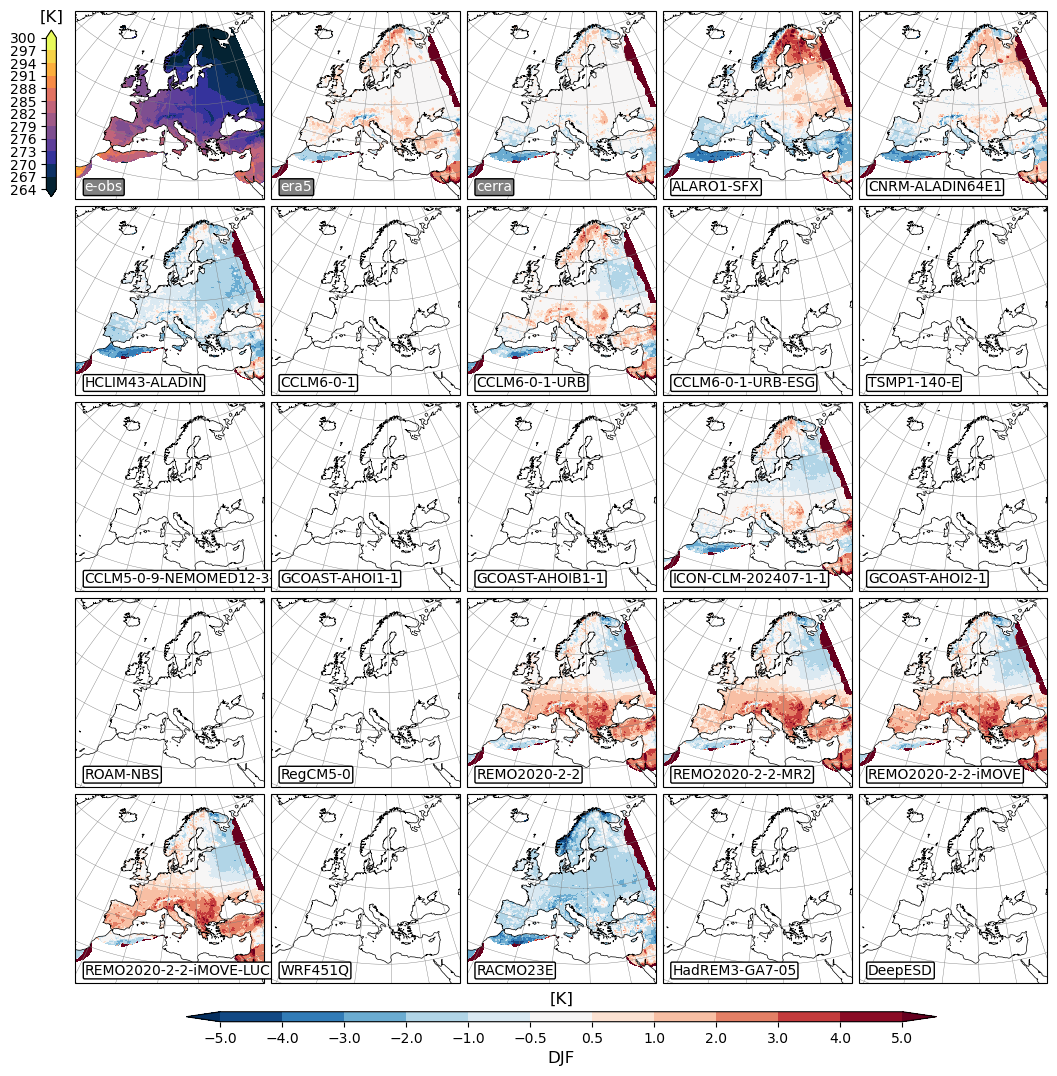

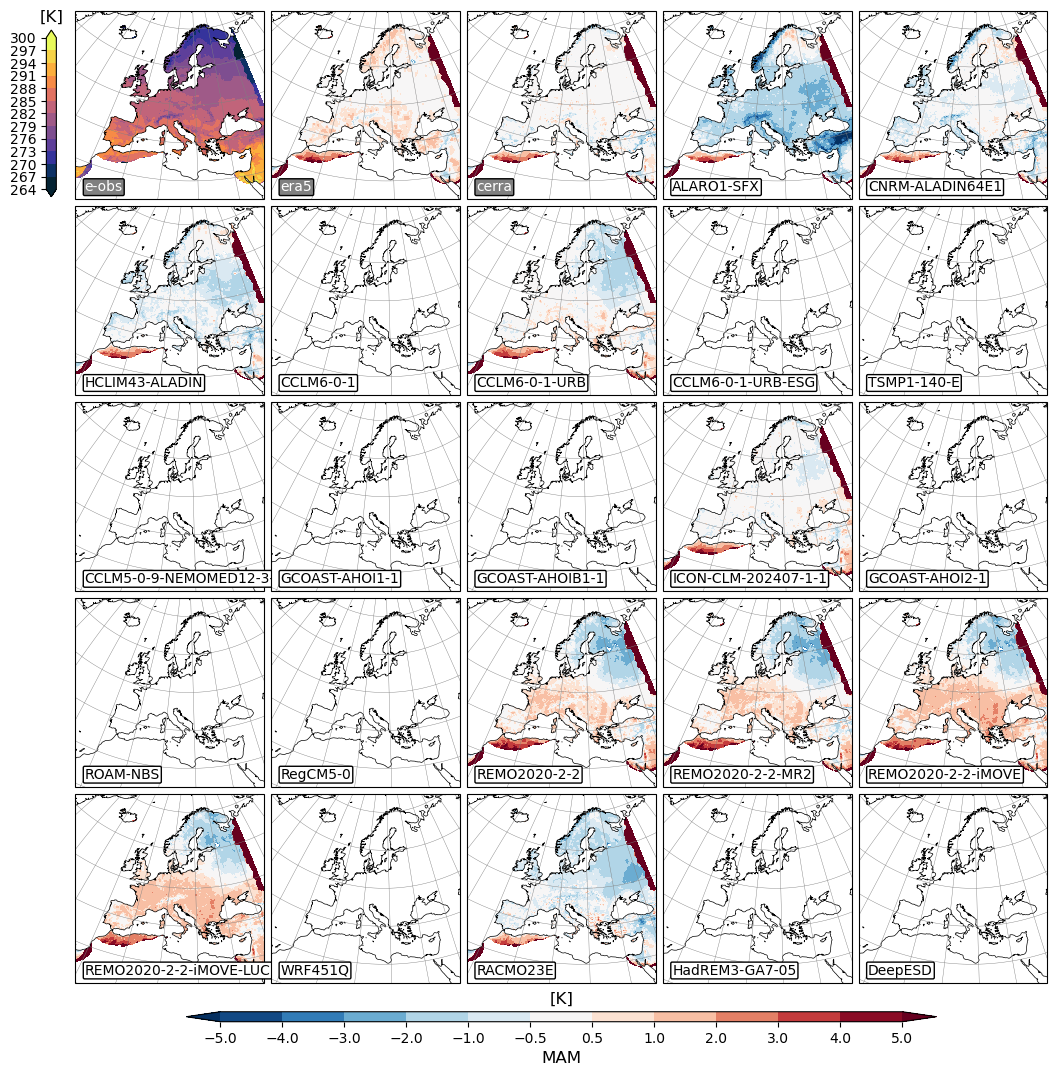

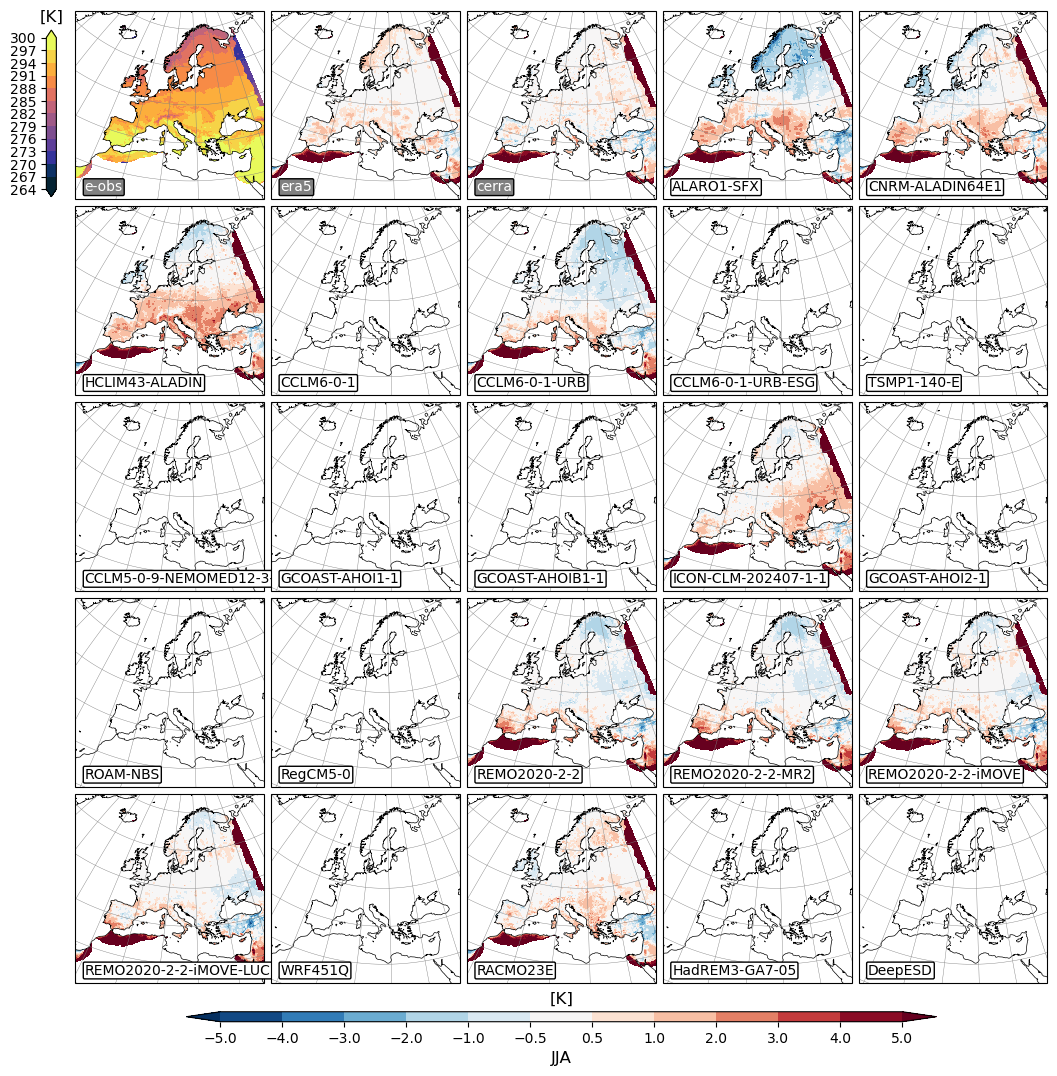

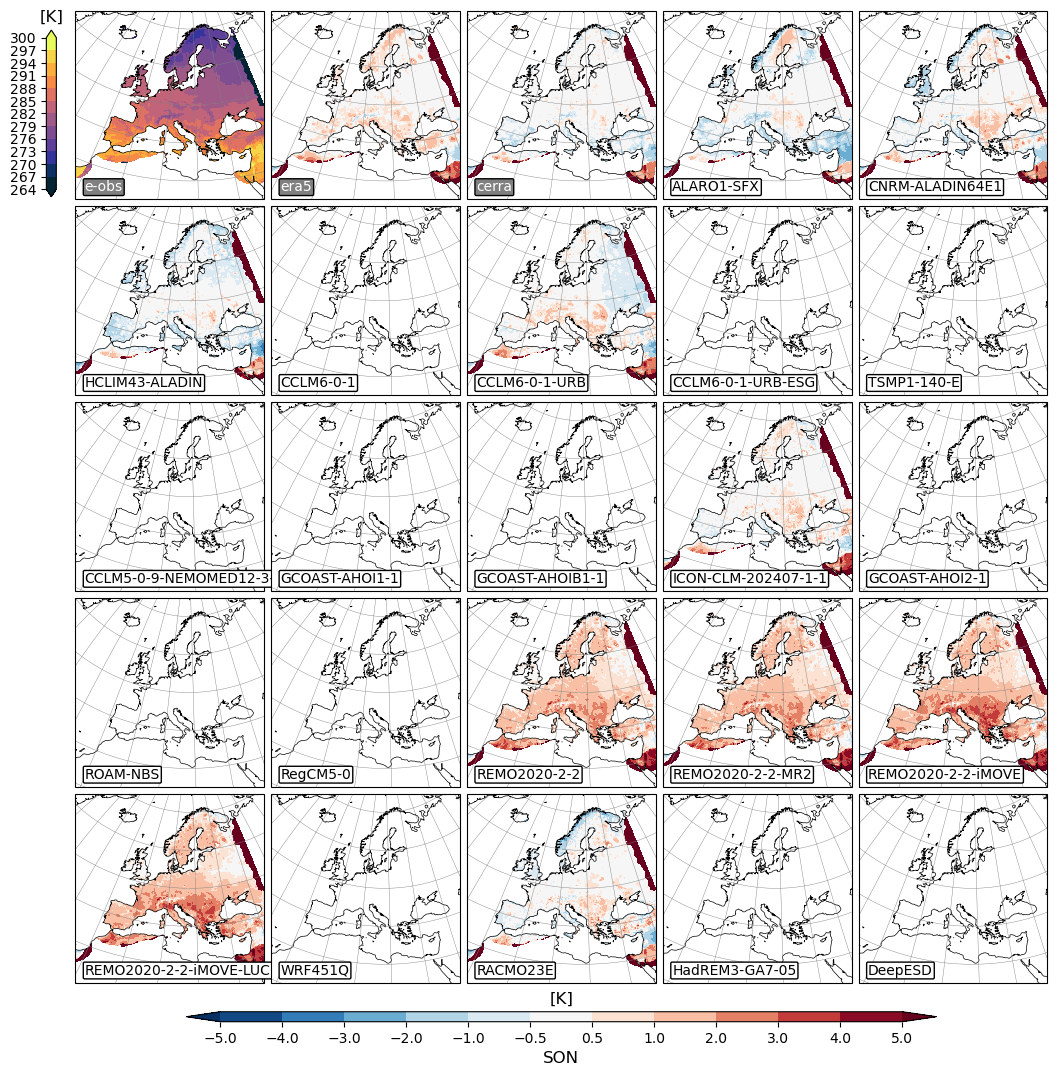

In [256]:
import warnings

warnings.warn("This is a FutureWarning example", FutureWarning)

for season in ["DJF", "MAM", "JJA", "SON"]:

    ncols = 5
    nrows = math.ceil(len(models_all) / ncols)
    transform = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162.0)
    projection = transform

    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        subplot_kw={"projection": projection},
        figsize=(ncols*2, nrows*2),
    )

    axs = axs.flatten()

    for n_m, model in enumerate(models_all):

        levels = var_dic[variable]["levels"]
        cmap = var_dic[variable]["cmap"]
        
        if "cmip5" in model:
            ds = CMIP5_seasonal_bias
            project = "cmip5"
            model = model.split(project + "_")[1]
        elif "cmip6" in model:
            ds = CMIP6_seasonal_bias
            project = "cmip6"
            model = model.split(project + "_")[1]
        elif "e-obs" == model:
            ds = ref_seasmean
            project = "e-obs"
            model = project
        else:
            ds = obs_seasonal_bias
            project = "obs"

        aspect = ds.cf.sizes["Y"] / ds.cf.sizes["X"]

        if project in ["obs", "cmip6", 'cmip5']:
            if model in ds.dset_id:
                data = (
                    ds[variable]
                    .isel(
                        season=np.where(ds.season == season)[0],
                        dset_id=np.where(ds.dset_id == model)[0],
                    )
                    .squeeze(dim=["season", "dset_id"])
                )
                cs = axs[n_m].contourf(
                    ds.cf["X"],
                    ds.cf["Y"],
                    data,
                    transform=transform,
                    levels=levels,
                    extend="both",
                    cmap=cmap,
                )
            else:
                cs = axs[n_m].contourf(
                        ds.cf["X"],
                        ds.cf["Y"],
                        data*np.nan,
                        transform=transform,
                        levels=levels,
                        extend="both",
                        cmap=cmap,
                    )

        elif project == 'e-obs':
            data = (
                ds
                .isel(season=np.where(ds.season == season)[0])
                .squeeze(dim=["season"])
            )
            
            n_colors = len(e_obs_dic[variable]["levels"]) - 1
            #cmap_eobs = plt.get_cmap(e_obs_dic[variable]["cmap"], n_colors)
            if variable == 'pr':
                data = data*30.5
            colors = e_obs_dic[variable]["cmap"](np.linspace(0, 1, n_colors))
            cmap_eobs = mcolors.ListedColormap(colors)
            norm = BoundaryNorm(e_obs_dic[variable]["levels"], ncolors=n_colors)
            c1 = axs[n_m].contourf(
                ds.cf["X"],
                ds.cf["Y"],
                data,
                transform=transform,
                levels=e_obs_dic[variable]["levels"],
                extend="both",
                cmap=cmap_eobs,
                norm=norm,
            )
            
        axs[n_m].set_aspect(round(aspect, 3))
        axs[n_m].coastlines(resolution="50m", color="black", linewidth=0.5)

        gl = axs[n_m].gridlines(
            draw_labels=False,
            linewidth=0.3,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
        )

        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axs[n_m].xaxis.set_major_formatter(lon_formatter)
        axs[n_m].yaxis.set_major_formatter(lat_formatter)

        if project == "cmip6":
            axs[n_m].set_title(
                model,
                loc="left",
                y=0,
                x=0.05,
                fontsize=10,
                bbox=dict(
                    facecolor="white", edgecolor="black", boxstyle="round,pad=0.1"
                ),
            )
        elif project == "cmip5":
            axs[n_m].set_title(model, loc="left", y=0, x=0.05, fontsize=10)
        elif project in ["obs", "e-obs"]:
            axs[n_m].set_title(
                model,
                loc="left",
                y=0,
                x=0.05,
                fontsize=10,
                color="white",
                bbox=dict(
                    facecolor="grey", edgecolor="black", boxstyle="round,pad=0.1"
                ),
            )

    cb1_ax = fig.add_axes([-0.015, 1-(1/nrows), 0.01, 1/(nrows+1)])
    cb1 = fig.colorbar(c1, cax=cb1_ax, ax=axs[0], orientation='vertical', 
                       location='left',  ticks=e_obs_dic[variable]["levels"],
                       spacing='uniform')
    cb1.ax.set_yticklabels([str(l) for l in e_obs_dic[variable]["levels"]])  # opcional: etiquetas como texto
    cb1.ax.tick_params(labelsize=10)
    cb1_ax.set_title(f"[{e_obs_dic[variable]['units']}]", fontsize=12)

    cbar_ax = fig.add_axes([0.125, -0.025, 0.75, 0.01])
    cbar = fig.colorbar(
        cs, cax=cbar_ax, orientation="horizontal", ticks=levels
    )
    cbar_ax.set_title(f"[{var_dic[variable]['units']}]", fontsize=12)
    cbar.ax.yaxis.set_ticks_position("left")
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(season, fontsize=12)

    for ax in axs[len(models_all) :]:
        ax.remove()

    for ax in axs:
        ax.set_aspect("auto")

    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)

    plt.savefig(
        f"{save_figure_path}/CMIP6-{parent_str}_eobs_{variable}_{season}_{period.start}-{period.stop}.png",
        bbox_inches="tight",
    )